In [488]:
# pip install xgboost

In [555]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost

# https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis

df = pd.read_excel('data/app_data.xlsx')

cond1 = df['Diagnosis'].notna()
cond2 = df['Body_Temperature']>30

df['has_appendicitis'] = (df['Diagnosis']=="appendicitis").astype('int')

df = df[cond1&cond2].reset_index(drop=True)

In [536]:
df.shape

(780, 58)

In [535]:
df.columns

Index(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management',
       'Severity', 'Diagnosis_Presumptive', 'Diagnosis', 'Alvarado_Score',
       'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter',
       'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'US_Number', 'Free_Fluids', 'Appendix_Wall_Layers',
       'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation',
       'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location',
       'Bowel

In [593]:
df['has_appendicitis'].value_counts()/len(df)

has_appendicitis
1    0.593023
0    0.406977
Name: count, dtype: float64

# Pediatric Appendicitis

In [534]:
df['Diagnosis'].fillna('').value_counts()

Diagnosis
appendicitis       463
no appendicitis    317
Name: count, dtype: int64

In [491]:
df['Severity'].fillna('').value_counts()

Severity
uncomplicated    661
complicated      119
Name: count, dtype: int64

In [492]:
df['Management'].fillna('').value_counts()

Management
conservative                 483
primary surgical             270
secondary surgical            26
simultaneous appendectomy      1
Name: count, dtype: int64

In [493]:
def count_nan(x):
    n_nan =  x.isna().sum()
    return {'n_nan': n_nan, 'total': len(x), 'pct_nan': round(n_nan/len(x), 4)}

df.groupby(['Diagnosis']).agg({'Appendix_Diameter': ['describe', count_nan]})

Appendix_Diameter                                           \
                         describe                                            
                            count      mean       std  min  25%  50%   75%   
Diagnosis                                                                    
appendicitis                371.0  8.695687  2.180152  4.4  7.0  8.2  10.0   
no appendicitis             127.0  5.037008  1.171541  2.7  4.0  5.0   5.5   

                                                                        
                                                             count_nan  
                  max                                Appendix_Diameter  
Diagnosis                                                               
appendicitis     17.0   {'n_nan': 92, 'total': 463, 'pct_nan': 0.1987}  
no appendicitis   9.5  {'n_nan': 190, 'total': 317, 'pct_nan': 0.5994}

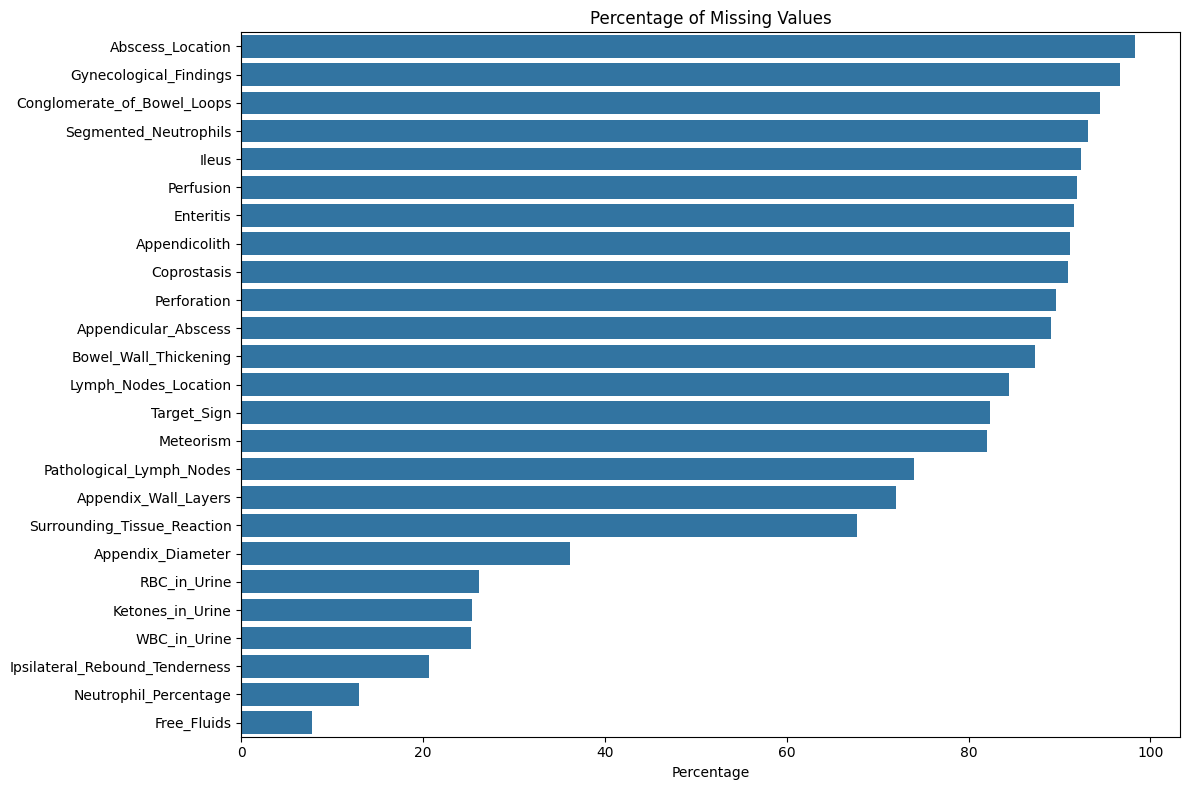

In [548]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

plt.figure(figsize=(12, 8))
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)[:25]

sns.barplot(data=missing_df[missing_df['Percentage'] > 0], 
            x='Percentage', y=missing_df[missing_df['Percentage'] > 0].index)
plt.ylabel('')
plt.title('Percentage of Missing Values')
plt.tight_layout()
plt.show()

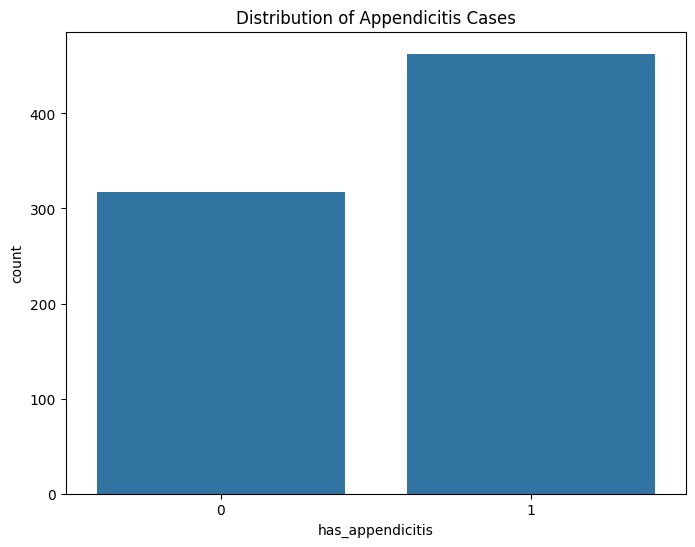

In [552]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='has_appendicitis')
plt.title('Distribution of Appendicitis Cases')
plt.show()

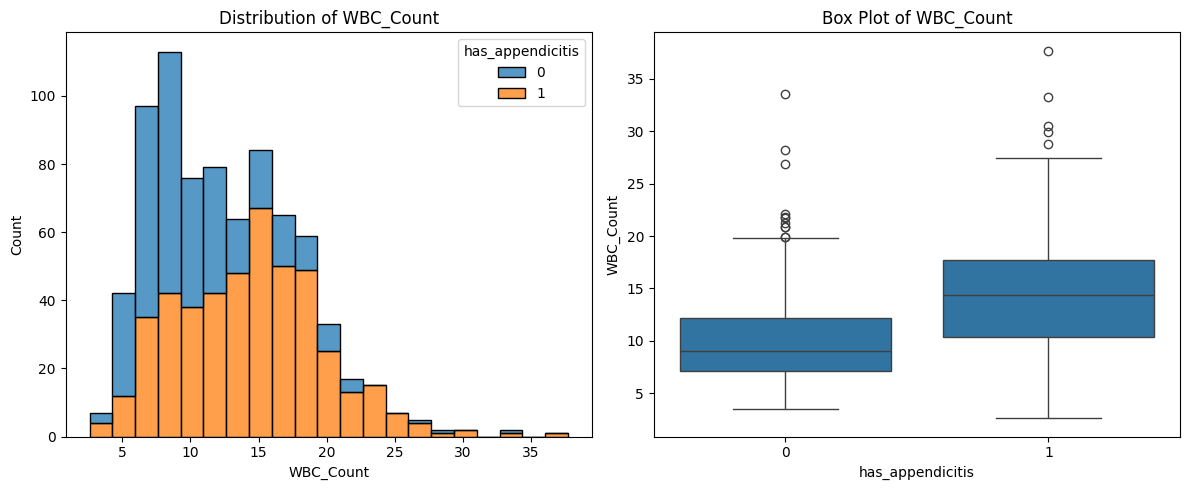

In [561]:
from scipy import stats

key_indicators = ['Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Body_Temperature', 'WBC_Count' ] #'CRP'

for indicator in key_indicators:
    plt.figure(figsize=(12, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=indicator, hue='has_appendicitis', multiple="stack")
    plt.title(f'Distribution of {indicator}')
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='has_appendicitis', y=indicator)
    plt.title(f'Box Plot of {indicator}')
    
    plt.tight_layout()
    plt.show()
    



# data prep


In [496]:

df = pd.read_excel('data/app_data.xlsx')

cond1 = df['Diagnosis'].notna()

df = df[cond1].reset_index(drop=True)

In [516]:
missing_pct = df.isna().sum()/len(df)*100
missing_pct[missing_pct > 80].sort_values(ascending=False)

Bowel_Wall_Thickening    87.307692
Target_Sign              82.307692
Meteorism                82.051282
dtype: float64

In [498]:
# transform target variable

df['has_appendicitis'] = (df['Diagnosis']=="appendicitis").astype('int')

#df['has_appendicitis'] = (df['Severity']=="complicated").astype('int')

# drop other target variables, we can't use them to predict
df.drop(columns=['Severity', 'Diagnosis', 'Management'], inplace=True)


# 'Diagnosis_Presumptive'
df.drop(columns=['Diagnosis_Presumptive', 'Length_of_Stay'], inplace=True)

# ultrasound
us_variables = ['Appendix_on_US', 'Appendix_Diameter', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 
                'Surrounding_Tissue_Reaction', 'Pathological_Lymph_Nodes','Bowel_Wall_Thickening', 'Coprostasis', 'Meteorism']

# drop variables that are not usually available (>90% nulls)
df.drop(columns=['Abscess_Location', 'Gynecological_Findings', 'Conglomerate_of_Bowel_Loops', 'Segmented_Neutrophils', 'Ileus',
                'Perfusion', 'Enteritis', 'Appendicolith', 'Coprostasis'], inplace=True)

In [499]:
def get_summary(var, data):
    pct_nan = round(df[var].isna().sum()/len(df)*100, 2)
    return f"{var}: {len(data.unique())} unique values: {df[var].unique()}.  {pct_nan}% null values"


binary_vars = ['Surrounding_Tissue_Reaction',  'Pathological_Lymph_Nodes', 'Dysuria', 'Bowel_Wall_Thickening', 
               'Conglomerate_of_Bowel_Loops',  'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
               'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite',
               # described as categorical, however, they are binary (yes/no) variables
               'Neutrophilia', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 
               'Free_Fluids', 'Target_Sign', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis']


binary_vars = [var for var in binary_vars if var in df.columns]

for var in binary_vars:
    print(get_summary(var, df[var]))


import numpy as np

for var in binary_vars:
    if df[var].dtype == 'O':
        df[var] = np.select([df[var]=='yes', df[var]=='no'], [1, 0], default=np.nan)

Surrounding_Tissue_Reaction: 3 unique values: ['yes' nan 'no'].  67.69% null values
Pathological_Lymph_Nodes: 3 unique values: ['yes' nan 'no'].  73.97% null values
Dysuria: 3 unique values: ['no' 'yes' nan].  3.46% null values
Bowel_Wall_Thickening: 3 unique values: [nan 'no' 'yes'].  87.31% null values
Appendix_on_US: 3 unique values: ['yes' 'no' nan].  0.38% null values
Migratory_Pain: 3 unique values: ['no' 'yes' nan].  0.9% null values
Lower_Right_Abd_Pain: 3 unique values: ['yes' 'no' nan].  0.77% null values
Contralateral_Rebound_Tenderness: 3 unique values: ['yes' 'no' nan].  1.67% null values
Coughing_Pain: 3 unique values: ['no' 'yes' nan].  1.79% null values
Nausea: 3 unique values: ['no' 'yes' nan].  0.77% null values
Loss_of_Appetite: 3 unique values: ['yes' 'no' nan].  1.03% null values
Neutrophilia: 3 unique values: ['no' 'yes' nan].  6.15% null values
Psoas_Sign: 3 unique values: ['yes' 'no' nan].  4.49% null values
Ipsilateral_Rebound_Tenderness: 3 unique values: ['no'

In [500]:
df['Sex'] = np.select([df['Sex']=='male', df['Sex']=='female', df['Sex']==np.nan], [1, 0, np.nan], default=np.nan)

In [501]:

# transform categorical variables
#df['Sex'] = df['Sex'].astype('category')

categorical_columns = df.select_dtypes(include=['object']).columns


for var in categorical_columns:
    print(get_summary(var, df[var]))

# Lymph_Nodes_Location, 

Ketones_in_Urine: 5 unique values: ['++' 'no' nan '+++' '+'].  25.38% null values
RBC_in_Urine: 5 unique values: ['+' 'no' nan '++' '+++'].  26.15% null values
WBC_in_Urine: 5 unique values: ['no' '+' nan '+++' '++'].  25.26% null values
Stool: 5 unique values: ['normal' 'constipation' 'diarrhea' nan 'constipation, diarrhea'].  1.92% null values
Peritonitis: 4 unique values: ['no' 'local' 'generalized' nan].  0.9% null values
Appendix_Wall_Layers: 5 unique values: ['intact' nan 'raised' 'upset' 'partially raised'].  72.05% null values
Perforation: 5 unique values: ['no' nan 'suspected' 'yes' 'not excluded'].  89.62% null values
Appendicular_Abscess: 4 unique values: ['no' nan 'suspected' 'yes'].  89.1% null values
Lymph_Nodes_Location: 27 unique values: ['reUB' nan 're UB' 'Ileozökal' 'UB' 're UB ' 'periumbilikal' 'ileocoekal'
 'mesenterial, re UB' 'mesenterial' 're UB, periumbilikal' 're UB  '
 're UB, ileocoecal' 'ileocoecal' 're UB, re MB' 'MB' 're MB' 'inguinal'
 'periappendikulär 

In [502]:
import unicodedata
import re

def clean_text(text):
    """
    Clean and normalize text to handle special characters and symbols
    """
    if pd.isna(text):
        return text
    
    text = str(text) #.lower()
    
    # Standardize plus symbols
    text = text.replace('+++', 'plus_3')
    text = text.replace('++', 'plus_2')
    text = text.replace('+', 'plus_1')
    
    # Standarize no
    if text.lower().strip() in ['no', 'keine',]:
        return 'no'
    
    # Remove special characters
    text = ''.join(char for char in unicodedata.normalize('NFKD', text)
                  if unicodedata.category(char)[0] != 'P' or char in 'äöüß')
      
    # Replace special characters with underscore
    text = re.sub(r'[^a-z0-9]+', '_', text)
    
    # Remove multiple underscores
    text = re.sub(r'_+', '_', text)
    text = text.strip('_')
    
    return text


for column in categorical_columns:
    # First clean the values in the original column
    df[column] = df[column].apply(clean_text)
    
    dummy_df = pd.get_dummies(df[column], prefix=column)

    for col in dummy_df.columns:
        dummy_df[col] = dummy_df[col].fillna(False).astype(bool)
    
    # Concatenate and drop original column
    df = pd.concat([df, dummy_df], axis=1).drop(column, axis=1)


#import pandas as pd

#for col in object_cols:
#  df[col] = df[col].fillna(False).astype(bool)

In [503]:
df.describe()

,Age,BMI,Sex,Height,Weight,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,...,Ipsilateral_Rebound_Tenderness,US_Performed,US_Number,Free_Fluids,Target_Sign,Surrounding_Tissue_Reaction,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Meteorism,has_appendicitis
count,780.000000,754.000000,779.000000,755.000000,778.000000,730.000000,730.000000,777.000000,498.000000,773.000000,...,619.000000,777.000000,759.000000,719.000000,138.000000,252.000000,203.000000,99.000000,140.000000,780.000000
mean,11.341863,18.905041,0.517330,147.997616,43.158625,5.921918,5.253425,0.648649,7.762651,0.272962,...,0.061389,0.981982,425.342556,0.431154,0.630435,0.825397,0.758621,0.555556,0.921429,0.593590
std,3.529881,4.387860,0.500021,19.737546,17.397830,2.155972,1.958456,0.477700,2.536671,0.445770,...,0.240237,0.133102,271.722277,0.495582,0.484445,0.380383,0.428978,0.499433,0.270035,0.491478
min,0.000000,7.827983,0.000000,53.000000,3.960000,0.000000,0.000000,0.000000,2.700000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.198426,15.721375,0.000000,137.000000,29.500000,4.000000,4.000000,0.000000,6.000000,0.000000,...,0.000000,1.000000,198.500000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,11.437372,18.044121,1.000000,149.500000,41.300000,6.000000,5.000000,1.000000,7.500000,0.000000,...,0.000000,1.000000,398.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,14.040383,21.185877,1.000000,163.000000,54.000000,8.000000,7.000000,1.000000,9.100000,1.000000,...,0.000000,1.000000,613.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,18.360000,38.156221,1.000000,192.000000,103.000000,10.000000,10.000000,1.000000,17.000000,1.000000,...,1.000000,1.000000,992.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [504]:
df.head()

,Age,BMI,Sex,Height,Weight,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,...,Lymph_Nodes_Location_periappendikula_r,Lymph_Nodes_Location_periumbilikal,Lymph_Nodes_Location_re,Lymph_Nodes_Location_re_ileocoecal,Lymph_Nodes_Location_re_periumbilikal,Lymph_Nodes_Location_re_re,Lymph_Nodes_Location_rechter_nter_und_ittelbauch,Lymph_Nodes_Location_rechter_nterbauch,Lymph_Nodes_Location_varialzysten,Lymph_Nodes_Location_ymphadenopathie
0,12.68,16.9,0.0,148.0,37.0,4.0,3.0,1.0,7.1,0.0,...,False,False,True,False,False,False,False,False,False,False
1,14.10,31.9,1.0,147.0,69.5,5.0,4.0,0.0,NaN,1.0,...,False,False,False,False,False,False,False,False,False,False
2,14.14,23.3,0.0,163.0,62.0,5.0,3.0,0.0,NaN,0.0,...,False,False,False,False,False,False,False,False,False,False
3,16.37,20.6,0.0,165.0,56.0,7.0,6.0,0.0,NaN,1.0,...,False,False,True,False,False,False,False,False,False,False
4,11.08,16.9,0.0,163.0,45.0,5.0,6.0,1.0,7.0,0.0,...,False,False,True,False,False,False,False,False,False,False


In [505]:
df['Ketones_in_Urine_no']

0      False
1       True
2       True
3       True
4       True
       ...  
775    False
776    False
777     True
778    False
779     True
Name: Ketones_in_Urine_no, Length: 780, dtype: bool

# Model

In [506]:
from sklearn.model_selection import train_test_split


target_variable = "has_appendicitis"
FeaturesName = df.columns.drop(target_variable)


X_train, X_test, Y_train, Y_test = train_test_split(
    df[FeaturesName], df[target_variable], test_size=0.20,)




In [507]:
Y_train.value_counts()/len(Y_train)

has_appendicitis
1    0.602564
0    0.397436
Name: count, dtype: float64

In [508]:
Y_test.value_counts()/len(Y_test)

has_appendicitis
1    0.557692
0    0.442308
Name: count, dtype: float64

In [509]:
X_train.shape, X_test.shape, 

((624, 86), (156, 86))

In [529]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

def classification_metric(Y_real, Y_pred):

    acc = accuracy_score(Y_real, Y_pred)
    precision = precision_score(Y_real, Y_pred)
    recall = recall_score(Y_real, Y_pred)
    f1 = f1_score(Y_real, Y_pred)
    roc = roc_auc_score(Y_real, Y_pred)
    
    metrics = pd.DataFrame({'accuracy' : [acc], 
                            'precision':[precision],
                            'recall':[recall],
                            'ROC':[roc], 
                            'F1': [f1]
                           })
    return metrics


def display_confusion_matrix(Y_real, y_pred):
    cm = confusion_matrix(Y_real, y_pred)
    
    TN = cm[0][0] 
    TP = cm[1][1] 
    FP = cm[0][1] 
    FN = cm[1][0] 
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    group_counts = ['{:,.0f}'.format(value) for value in
                    cm.flatten()]
    
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')
    plt.title('Confusion Matrix: \n Has apendicitis: levels: Yes No', fontsize = 10) 
    plt.xlabel('', fontsize = 15) 
    plt.ylabel('', fontsize = 15)
    
    print("Sum of TP + TN + FP + FN = ", str(TP) + " + " + str(TN) + " + " +str(FP)+ " + "+ str(FN), " = " + str(TP+TN+FP+FN))
    print(len(Y_real) == TP+TN+FP+FN)


## Random Forest Classifier

In [589]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np


param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample', None]
}


rf = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25, 
    cv=5,
    scoring='f1',  # 'f1', 'precision', 'recall'
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
best_rf = random_search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.22959818254342154, classifier__max_depth=7, classifier__min_child_weight=2, classifier__n_estimators=566, classifier__reg_alpha=0.5, classifier__reg_lambda=1.0, classifier__scale_pos_weight=5, classifier__subsample=0.9464704583099741, imputer__strategy=most_frequent; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8721230154351118, classifier__gamma=0.2252496259847715, classifier__learning_rate=0.013979488347959958, classifier__max_depth=11, classifier__min_child_weight=4, classifier__n_estimators=113, classifier__reg_alpha=0.1, classifier__reg_lambda=0.5, classifier__scale_pos_weight=1, classifier__subsample=0.6063865008880857, imputer__strategy=median; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8721230154351118, classifier__gamma=0.2252496259847715, classifier__learning_rate=

Train


,accuracy,precision,recall,ROC,F1
0,1.0,1.0,1.0,1.0,1.0


Test:


,accuracy,precision,recall,ROC,F1
0,0.929487,0.94186,0.931034,0.929285,0.936416


Sum of TP + TN + FP + FN =  81 + 64 + 5 + 6  = 156
True


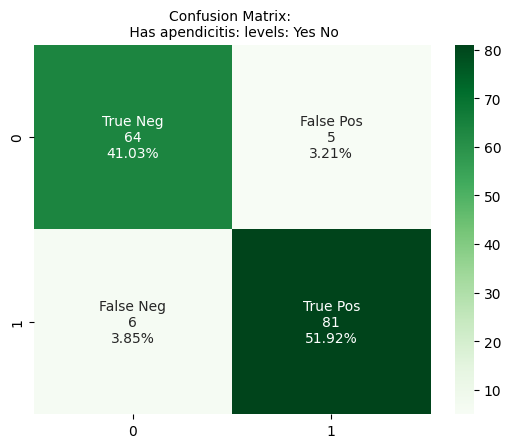

In [590]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)


print("Train")
display(classification_metric(Y_train, y_pred_train))

print("Test:")

display(classification_metric(Y_test, y_pred_test))

display_confusion_matrix(Y_test, y_pred_test)

In [591]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                                  feature  importance
8                       Appendix_Diameter    0.261567
28                              US_Number    0.107265
7                          Appendix_on_US    0.075844
26         Ipsilateral_Rebound_Tenderness    0.065936
31            Surrounding_Tissue_Reaction    0.059481
..                                    ...         ...
79     Lymph_Nodes_Location_re_ileocoecal    0.000000
80  Lymph_Nodes_Location_re_periumbilikal    0.000000
81             Lymph_Nodes_Location_re_re    0.000000
70          Lymph_Nodes_Location_inguinal    0.000000
57             Appendix_Wall_Layers_upset    0.000000

[86 rows x 2 columns]
[CV] END classifier__colsample_bytree=0.608233797718321, classifier__gamma=0.48495492608099716, classifier__learning_rate=0.2597327922401265, classifier__max_depth=8, classifier__min_child_weight=2, classifier__n_estimators=291, classifier__reg_alpha=1.0, classifier__reg_lambda=0.1, classifier__scale_pos_we

## AdaBoostClassifier

In [578]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


ada_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # 'median', 'most_frequent', 'constant'
    ('classifier', AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=200,
        algorithm="SAMME.R", 
        learning_rate=0.5))
])

param_dist = {
    # AdaBoost parameters
    'classifier__n_estimators': randint(50, 500),
    'classifier__learning_rate': uniform(0.01, 1.0),
    'classifier__algorithm': ['SAMME'],

    # Estimator (DecisionTreeClassifier) params
    'classifier__estimator__max_depth': randint(1, 10),
    'classifier__estimator__min_samples_split': randint(2, 20),
    'classifier__estimator__min_samples_leaf': randint(1, 10),
    'classifier__estimator__criterion': ['gini', 'entropy'],
    
    # Imputer parameters
    'imputer__strategy': ['mean', 'median', 'most_frequent']
}


random_search = RandomizedSearchCV(
    estimator=ada_clf,
    param_distributions=param_dist,
    n_iter=25, 
    cv=5,
    scoring='f1',  # 'f1', 'precision', 'recall'
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
ada_clf = random_search.best_estimator_


#ada_clf.fit(X_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found:
{'classifier__algorithm': 'SAMME', 'classifier__estimator__criterion': 'entropy', 'classifier__estimator__max_depth': 7, 'classifier__estimator__min_samples_leaf': 3, 'classifier__estimator__min_samples_split': 3, 'classifier__learning_rate': np.float64(0.6343540481337933), 'classifier__n_estimators': 111, 'imputer__strategy': 'mean'}

Best cross-validation score: 0.968


Train


,accuracy,precision,recall,ROC,F1
0,1.0,1.0,1.0,1.0,1.0


Test:


,accuracy,precision,recall,ROC,F1
0,0.974359,0.977011,0.977011,0.974013,0.977011


Sum of TP + TN + FP + FN =  85 + 67 + 2 + 2  = 156
True


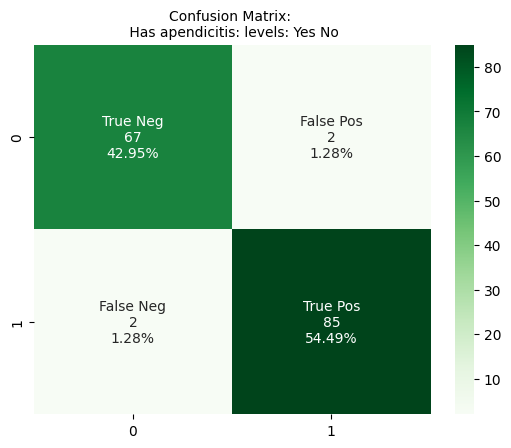

In [579]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred_train = ada_clf.predict(X_train)
y_pred_test = ada_clf.predict(X_test)


print("Train")
display(classification_metric(Y_train, y_pred_train))

print("Test:")
display(classification_metric(Y_test, y_pred_test))


display_confusion_matrix(Y_test, y_pred_test)

## XGBClassifier

In [581]:
import xgboost as xgb
from scipy.stats import randint, uniform

param_dist = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__min_child_weight': randint(1, 7),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__reg_alpha': [0, 0.1, 0.5, 1.0],
    'classifier__reg_lambda': [0.1, 0.5, 1.0, 5.0],
    'classifier__scale_pos_weight': [1, 3, 5],
    
    # Imputer parameters
    'imputer__strategy': ['mean', 'median', 'most_frequent']
}


xgb_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        seed=42))
])


random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Increased due to larger parameter space
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
xbg_1 = random_search.best_estimator_


#ada_clf.fit(X_train, Y_train)
#xbg_1 = xgb.XGBClassifier(objective = "binary:logistic", seed=42, max_depth=5)
#xbg_1.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:
{'classifier__colsample_bytree': np.float64(0.8048372233197124), 'classifier__gamma': np.float64(0.11324788759896898), 'classifier__learning_rate': np.float64(0.20355183712283495), 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 739, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 0.5, 'classifier__scale_pos_weight': 1, 'classifier__subsample': np.float64(0.8702760468157122), 'imputer__strategy': 'mean'}

Best cross-validation score: 0.963


Train


,accuracy,precision,recall,ROC,F1
0,1.0,1.0,1.0,1.0,1.0


Test:


,accuracy,precision,recall,ROC,F1
0,0.948718,0.964706,0.942529,0.949525,0.953488


Sum of TP + TN + FP + FN =  82 + 66 + 3 + 5  = 156
True


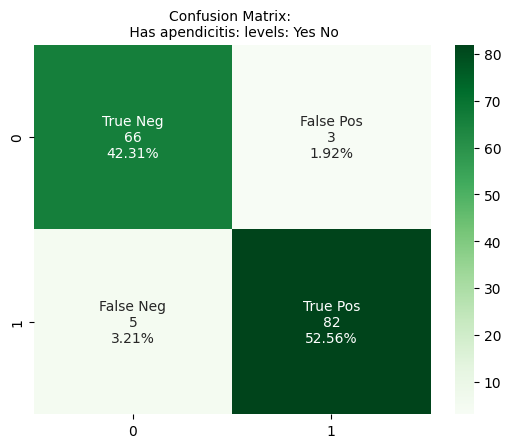

In [583]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred_train = xbg_1.predict(X_train)
y_pred_test = xbg_1.predict(X_test)


print("Train")
display(classification_metric(Y_train, y_pred_train))

print("Test:")
display(classification_metric(Y_test, y_pred_test))

display_confusion_matrix(Y_test, y_pred_test)
